In [1]:
!echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   136k      0 --:--:-- --:--:-- --:--:--  136k
OK


In [2]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tensorflow-model-server is already the newest version (2.2.0).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.


In [3]:
!pip install requests

In [4]:
import os
import json
import random
import requests
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10

%matplotlib inline
tf.__version__

'2.2.0'

In [5]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [8]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

In [9]:
model.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])

In [10]:
model.fit(X_train, 
          y_train, 
          batch_size=128, 
          epochs=10)

Epoch 1/10
391/391 [==============================] - 8s 21ms/step - loss: 1.4715 - sparse_categorical_accuracy: 0.4691
Epoch 2/10
391/391 [==============================] - 8s 21ms/step - loss: 1.0322 - sparse_categorical_accuracy: 0.6387
Epoch 3/10
391/391 [==============================] - 8s 21ms/step - loss: 0.8359 - sparse_categorical_accuracy: 0.7097
Epoch 4/10
391/391 [==============================] - 8s 21ms/step - loss: 0.7152 - sparse_categorical_accuracy: 0.7531
Epoch 5/10
391/391 [==============================] - 8s 21ms/step - loss: 0.6155 - sparse_categorical_accuracy: 0.7869
Epoch 6/10
391/391 [==============================] - 8s 21ms/step - loss: 0.5285 - sparse_categorical_accuracy: 0.8169
Epoch 7/10
391/391 [==============================] - 8s 20ms/step - loss: 0.4480 - sparse_categorical_accuracy: 0.8436
Epoch 8/10
391/391 [==============================] - 8s 21ms/step - loss: 0.3714 - sparse_categorical_accuracy: 0.8714
Epoch 9/10
391/391 [====================

In [11]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.9967 - sparse_categorical_accuracy: 0.7393


In [12]:
print("Test accuracy is {}".format(test_accuracy))

Test accuracy is 0.739300012588501


In [13]:
10000/128

78.125

In [14]:
MODEL_DIR = "model/"
version = 1

In [15]:
export_path = os.path.join(MODEL_DIR, str(version))
export_path

'model/1'

In [16]:
if os.path.isdir(export_path):
    !rm -r {export_path}

In [17]:
tf.saved_model.save(model,export_dir=export_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/1/assets


In [18]:
os.environ['MODEL_DIR'] = os.path.abspath(MODEL_DIR)

In [19]:
%%bash --bg
nohup tensorflow_model_server --rest_api_port=8505 --model_name=cifar10 --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [20]:
!tail server.log

2020-07-04 11:14:30.845473: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:183] Running initialization op on SavedModel bundle at path: /content/model/1
2020-07-04 11:14:30.854643: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:364] SavedModel load for tags { serve }; Status: success: OK. Took 80242 microseconds.
2020-07-04 11:14:30.855858: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:105] No warmup data file found at /content/model/1/assets.extra/tf_serving_warmup_requests
2020-07-04 11:14:30.856010: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: cifar10 version: 1}
2020-07-04 11:14:30.857292: I tensorflow_serving/model_servers/server.cc:355] Running gRPC ModelServer at 0.0.0.0:8500 ...
[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 223] NET_LOG: Couldn't bind to port 8505
[evhttp_server.cc : 63] NET_LOG: Server has not been terminated. Force termination now

In [21]:
random_image = np.random.randint(0, len(X_test))
random_image

5109

In [22]:
data = json.dumps({"signature_name":"serving_default", "instances":[X_test[random_image].tolist()]})

In [23]:
data

'{"signature_name": "serving_default", "instances": [[[[0.6862745098039216, 0.7215686274509804, 0.807843137254902], [0.6901960784313725, 0.7098039215686275, 0.803921568627451], [0.7098039215686275, 0.7215686274509804, 0.8117647058823529], [0.7411764705882353, 0.7490196078431373, 0.8313725490196079], [0.7568627450980392, 0.7647058823529411, 0.8470588235294118], [0.7725490196078432, 0.7803921568627451, 0.8627450980392157], [0.8, 0.8, 0.8666666666666667], [0.8117647058823529, 0.803921568627451, 0.8588235294117647], [0.8156862745098039, 0.803921568627451, 0.8627450980392157], [0.807843137254902, 0.8, 0.8588235294117647], [0.8, 0.788235294117647, 0.8588235294117647], [0.796078431372549, 0.788235294117647, 0.8588235294117647], [0.796078431372549, 0.7843137254901961, 0.8549019607843137], [0.803921568627451, 0.792156862745098, 0.8588235294117647], [0.803921568627451, 0.796078431372549, 0.8509803921568627], [0.803921568627451, 0.8, 0.8549019607843137], [0.807843137254902, 0.8, 0.854901960784313

In [24]:
headers = {"content-type":"application/json"}

In [25]:
json_response = requests.post(url="http://localhost:8505/v1/models/cifar10:predict", data=data, headers=headers)

In [26]:
json_response

<Response [200]>

In [27]:
predictions = json.loads(json_response.text)['predictions']

In [29]:
predictions

[[3.04622017e-06,
  1.6140719e-08,
  6.02296771e-12,
  1.91293379e-12,
  3.3054197e-14,
  1.58935311e-13,
  1.12374675e-13,
  2.24879924e-12,
  1.41038328e-07,
  0.999996781]]

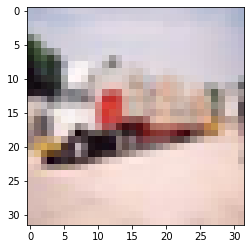

In [30]:
plt.imshow(X_test[random_image])

In [31]:
class_names[np.argmax(predictions[0])]

'truck'